In [128]:
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
settings = np.seterr(divide = 'ignore')

In [129]:
# Calculates the Sobel gradient magnitude of a given image (np.array)
def calculate_gradient(npimg):
    # Define the Sobel kernels
    sobel_gx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobel_gy = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    
    # Calculate x and y gradients
    edges_x = cv2.filter2D(npimg, -1, sobel_gx)
    edges_y = cv2.filter2D(npimg, -1, sobel_gy)
    
    # Calculate the magnitude of the gradient
    sobelMag = np.sqrt(edges_x * edges_x + edges_y * edges_y)
    return sobelMag

In [130]:
def SceneSegmentation(img, partition_size, num_scenes):
    # Make sure image is a numpy array of appropriate dimensions
    img = np.array(img.convert('L'))

    # Initialize variables
    (m, n) = img.shape
    k = num_scenes
    (x, y) = partition_size
    (p, q) = (m // x, n // y) # Number of partitions
    
    # Get V values for partitions
    V_vals = []
    for i in range(p):
        for j in range(q):
            subimage_ij = img[i*x:(i+1)*x-1,j*y:(j+1)*y-1]
            subimage_ig_flat = subimage_ij.flatten()
            V_ij = np.mean(subimage_ig_flat) - np.std(subimage_ig_flat)
            V_vals.append(V_ij)
            
    # Compute Vsort
    V_sort = np.sort(V_vals)
    l = V_sort.shape[0]
    
    # Segment the image by classifying the pixels based on the V values
    V_pq = np.reshape(V_vals, (p, q))
    V_matrix = np.zeros(img.shape)
    C_matrix = np.zeros(img.shape)
    for a in range(m):
        for b in range(n):
            V_matrix[a, b] = V_pq[a // x, b // y]
            for i in range(k):
                left_index = max(math.floor(i*l/k)-1, 0)
                right_index = min(math.floor((i+1)*l/k), l-1)
                if V_sort[left_index] <= V_matrix[a, b] <= V_sort[right_index]:
                    C_matrix[a, b] = i + 1
                    break
                    
    return C_matrix, V_matrix

In [131]:
def SceneLuminance(img, C_matrix, num_scenes):
    # Make sure image is a numpy array of appropriate dimensions
    img = np.array(img)
    
    # Initialize variables
    (m, n, _) = img.shape
    k = num_scenes
    
    # Separate images into channels
    img_R = img[:,:,0].copy()
    img_G = img[:,:,1].copy()
    img_B = img[:,:,2].copy()
    
    # Erode the channels separately
    struct_ele = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    img_RE = cv2.erode(img_R, struct_ele, iterations=1)
    img_GE = cv2.erode(img_G, struct_ele, iterations=1)
    img_BE = cv2.erode(img_B, struct_ele, iterations=1)
    
    # Get luminance for each scene
    L_matrix = np.zeros(img.shape)
    for i in range(1, k+1):
        # Extract values of red, blue and green pixels in each scene
        scene_mask = C_matrix == i
        IR_scene = img_RE[scene_mask].flatten()
        IG_scene = img_GE[scene_mask].flatten()
        IB_scene = img_BE[scene_mask].flatten()
        numpixels_scene = IR_scene.shape[0] # Number of pixels in each scene (same for all channels)
        
        # Get top 10% values for each channel in the scene
        topvalues_R = IR_scene[np.argpartition(IR_scene, math.floor(0.1 * numpixels_scene))[-numpixels_scene:]]
        topvalues_G = IG_scene[np.argpartition(IG_scene, math.floor(0.1 * numpixels_scene))[-numpixels_scene:]]
        topvalues_B = IB_scene[np.argpartition(IB_scene, math.floor(0.1 * numpixels_scene))[-numpixels_scene:]]
        
        # Get average of top 10% values
        avg_R = np.average(topvalues_R)
        avg_G = np.average(topvalues_G)
        avg_B = np.average(topvalues_B)
        
        # Set luminance values for each pixel in this scene
        tempR = np.zeros((m, n))
        tempG = np.zeros((m, n))
        tempB = np.zeros((m, n))
        tempR[scene_mask] = avg_R
        tempG[scene_mask] = avg_G
        tempB[scene_mask] = avg_B
        L_matrix[:,:,0] += tempR.copy()
        L_matrix[:,:,1] += tempG.copy()
        L_matrix[:,:,2] += tempB.copy()
        
    return L_matrix

In [132]:
def SceneTransmission(img, Segments, L_matrix, num_scenes, omega = 0.15):
    # Make sure image is a numpy array of appropriate dimensions
    img = np.array(img)
    
    # Initialize variables
    (m, n, _) = img.shape
    k = num_scenes
    (C_matrix, V_matrix) = Segments
    
    # Separate images into channels
    img_R = img[:,:,0].copy()
    img_G = img[:,:,1].copy()
    img_B = img[:,:,2].copy()
    
    # Calculate T (T_tilde) for all scenes
    T_cap_matrix = np.zeros((m, n), dtype=np.float64)
    chi_matrix = np.zeros((m, n), dtype=np.float64)
    
    for i in range(1, k+1):
        scene_mask = C_matrix == i # Map for the scene
        
        # Minimising by varing T_cap
        min_val = math.inf
        T_cap_scene = 0.1
        for t in np.arange(0.1, 1, 0.01):
            # Intermediate images
            inter_R = 1 + ((img_R - L_matrix[:,:,0]) / (L_matrix[:,:,0] * t))
            inter_B = 1 + ((img_B - L_matrix[:,:,1]) / (L_matrix[:,:,1] * t))
            inter_G = 1 + ((img_G - L_matrix[:,:,2]) / (L_matrix[:,:,2] * t))
            # Calculating Gradients
            grad_R = calculate_gradient(inter_R)
            grad_G = calculate_gradient(inter_G)
            grad_B = calculate_gradient(inter_B)
            # Calculating intermediate values
            val_R = grad_R[scene_mask].sum()
            val_G = grad_G[scene_mask].sum()
            val_B = grad_B[scene_mask].sum()
            
            # Adjusting T_cap if necessary
            val_scene = -(val_R + val_G + val_B)
            if val_scene < min_val:
                min_val = val_scene
                T_cap_scene = t
                
        # Setting T_cap for each scene
        T_cap_matrix[scene_mask] = T_cap_scene
        
        # Calculating & setting Chi value
        scene_size = scene_mask.sum()
        sigma_Vxy = V_matrix[scene_mask].sum()
        chi_scene = sigma_Vxy / scene_size
        chi_matrix[scene_mask] = chi_scene
        
    # Chi matrix scaled to [0, 1]
    chi_matrix = (chi_matrix - chi_matrix.min()) / (chi_matrix.max() - chi_matrix.min())
    
    # Calculating M matrix
    M_matrix = 2 - np.exp(-(((chi_matrix - 0.5)**2) / (2 * (omega**2))))
    
    # Storing T values
    T_matrix = T_cap_matrix * M_matrix
        
    return T_matrix

In [133]:
def EdgeOptimization(img, map_to_refine, num_scenes, eps_err = 0.0001, alpha=3, beta=0, gamma=4):
    # Make sure image is a numpy array of appropriate dimensions
    G = np.array(img.convert('L'))
    
    # Initialize variables
    (m, n) = G.shape
    k = num_scenes
    r = max(m, n) // k
    r -= 1 if r % 2 == 0 else 0 # Make sure r is odd
    
    # Calculate W
    G_grad = calculate_gradient(G)
    W = 1 - np.exp(-G_grad)

    # Define filters for calculating Trefine-i and Gi
    refine_filter = np.ones((r, r))
    refine_filter[r//2, r//2] = 0
    
    G_filter = -np.ones((r, r))
    G_filter[r//2, r//2] = r**2 - 1

    # Calculate epsilon_iter
    def getEpsilon(refine_new, refine_old):
        diff = refine_new - refine_old
        diff_norm = np.linalg.norm(diff)
        epsilon = (diff_norm**2) / (m * n)
        return epsilon

    # Iterate until convergence
    epsilon = math.inf
    refine = map_to_refine.copy()
    num_iter = 0
    while epsilon > eps_err:
        num_iter += 1

        # Update beta
        beta = 3 * (num_iter - 1)
        
        # alpha * map_to_refine
        nr_term1 = alpha * map_to_refine

        # gamma * W * sum(G - Gi)
        nr_term2 = gamma * W * cv2.filter2D(G, -1, G_filter)

        # Trefine-i terms
        nr_term3 = (W * (gamma - beta) + beta) * cv2.filter2D(refine, -1, refine_filter)

        # Denominator
        dr_term = alpha + (r**2 - 1) * (W * (gamma - beta) + beta)

        # Calculate new map
        refine_new = (nr_term1 + nr_term2 + nr_term3) / dr_term

        # Calculate epsilon
        epsilon = getEpsilon(refine_new, refine)

        # Update refine
        refine = refine_new

    return refine

In [134]:
def RestoreImage(img, T_refine, L_refine):
    # Make sure image is a numpy array of appropriate dimensions
    img = np.array(img)
    
    # Initialize variables
    (LR_refine, LG_refine, LB_refine) = L_refine

    # Split image into channels
    img_R = img[:,:,0]
    img_G = img[:,:,1]
    img_B = img[:,:,2]

    # Calculate Scene Reflectance
    rho_R = 1 + ((img_R - LR_refine) / (LR_refine * T_refine))
    rho_G = 1 + ((img_G - LG_refine) / (LG_refine * T_refine))
    rho_B = 1 + ((img_B - LB_refine) / (LB_refine * T_refine))

    # Restrict rho values
    dehazed_R = np.clip(rho_R, 0, 1)
    dehazed_G = np.clip(rho_G, 0, 1)
    dehazed_B = np.clip(rho_B, 0, 1)

    # Combine channels
    dehazed = np.dstack((dehazed_R, dehazed_G, dehazed_B))

    return dehazed

In [137]:
# Returns intermediate images for each step of the algorithm
def DehazeImage(img, partition_size=(8,8), num_scenes=15, omega=0.15, eps_errs=(0.0001,0.0001), edge_opt_hyperparams=(3,0,4)):
    # Initialize variables
    (eps_err_T, eps_err_L) = eps_errs
    (alpha, beta, gamma) = edge_opt_hyperparams
    
    # Scene Segmentation
    C_matrix, V_matrix = SceneSegmentation(img, partition_size, num_scenes)

    # Rough estimate of Scene Luminance
    L_matrix = SceneLuminance(img, C_matrix, num_scenes)

    # Rough extimate of Scene Transmission
    T_matrix = SceneTransmission(img, (C_matrix, V_matrix), L_matrix, num_scenes, omega)

    # Edge Optimization
    T_refine = EdgeOptimization(img, T_matrix, num_scenes, eps_err_T, alpha, beta, gamma)
    LR_refine = EdgeOptimization(img, L_matrix[:,:,0], num_scenes, eps_err_L, alpha, beta, gamma)
    LG_refine = EdgeOptimization(img, L_matrix[:,:,1], num_scenes, eps_err_L, alpha, beta, gamma)
    LB_refine = EdgeOptimization(img, L_matrix[:,:,2], num_scenes, eps_err_L, alpha, beta, gamma)

    # Restore Image
    dehazed_img = RestoreImage(img, T_refine, (LR_refine, LG_refine, LB_refine))

    return ((C_matrix, V_matrix), L_matrix, T_matrix, (T_refine, LR_refine, LG_refine, LB_refine), dehazed_img)


In [149]:
img = Image.open('img/hazy.jpg')
outputs = DehazeImage(img, (10,10), 15, 0.15, (0.001,0.1), (3,0,4))
((C_matrix, V_matrix), L_matrix, T_matrix, (T_refine, LR_refine, LG_refine, LB_refine), dehazed_img) = outputs

## Scene Segmentation

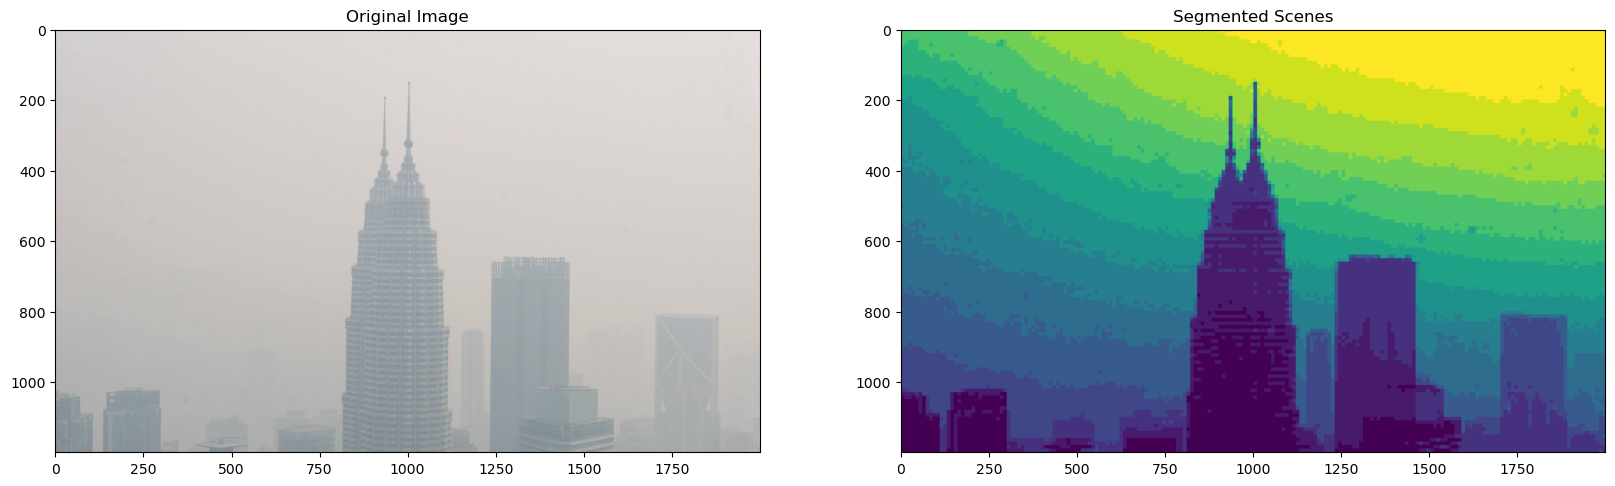

In [150]:
plt.figure(figsize=(20,20))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.title('Segmented Scenes')
plt.imshow(C_matrix)
plt.show()

## Rough estimate of Scene Luminance

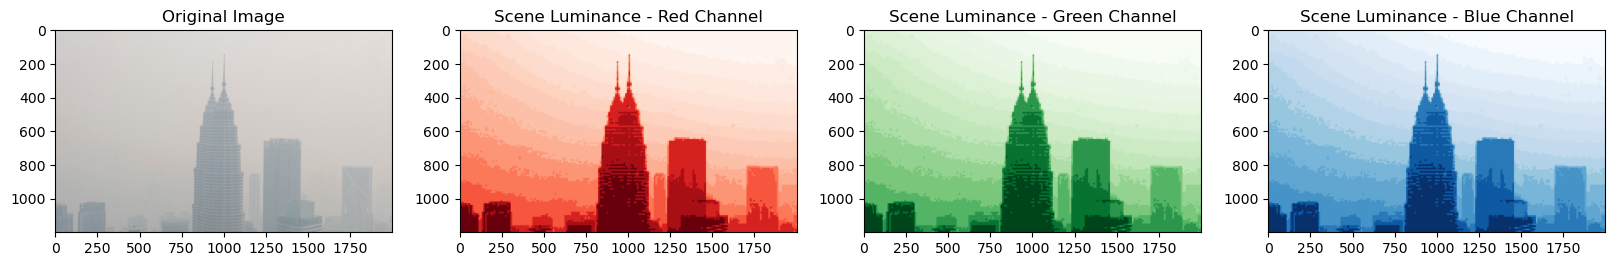

In [151]:
plt.figure(figsize=(20,20))
plt.subplot(1, 4, 1)
plt.title('Original Image')
plt.imshow(img)
plt.subplot(1, 4, 2)
plt.title('Scene Luminance - Red Channel')
plt.imshow(L_matrix[:,:,0], cmap=plt.cm.Reds_r)
plt.subplot(1, 4, 3)
plt.title('Scene Luminance - Green Channel')
plt.imshow(L_matrix[:,:,1], cmap=plt.cm.Greens_r)
plt.subplot(1, 4, 4)
plt.title('Scene Luminance - Blue Channel')
plt.imshow(L_matrix[:,:,2], cmap=plt.cm.Blues_r)
plt.show()

## Rough estimate of Scene Transmission

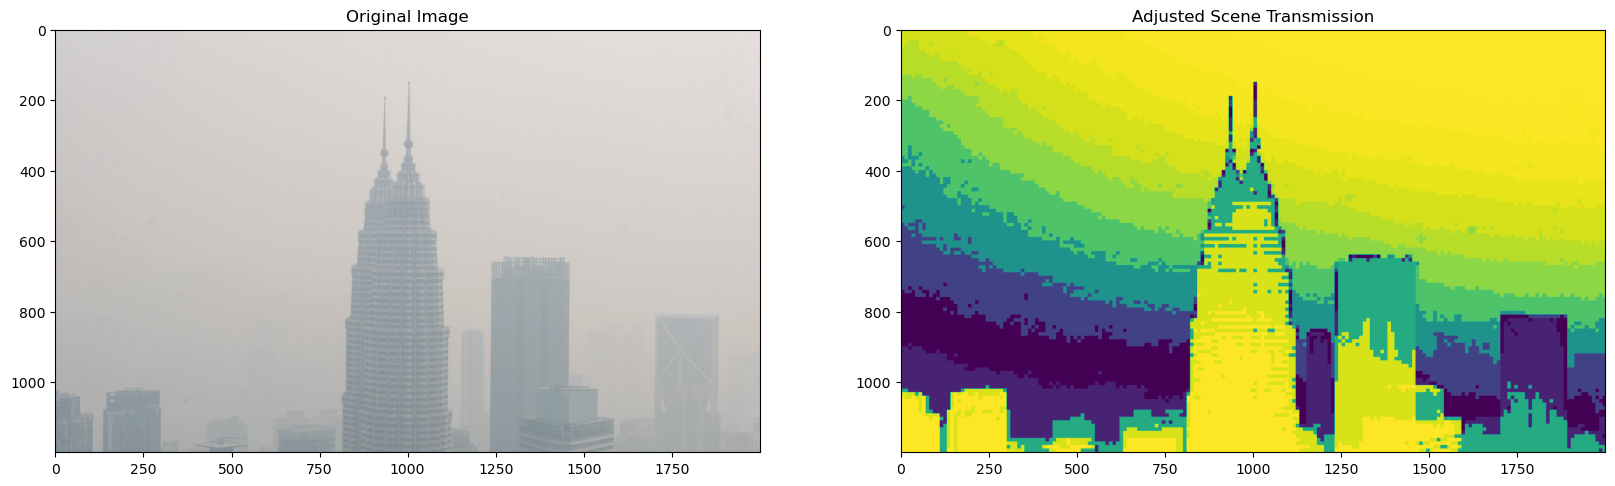

In [152]:
plt.figure(figsize=(20,20))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.title('Adjusted Scene Transmission')
plt.imshow(T_matrix)
plt.show()

## Edge Optimization

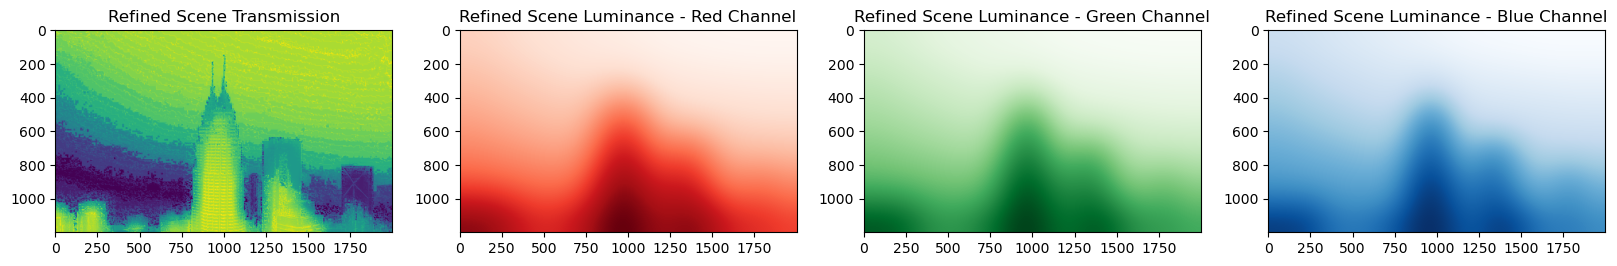

In [156]:
plt.figure(figsize=(20,20))
plt.subplot(1, 4, 1)
plt.title('Refined Scene Transmission')
plt.imshow(T_refine)
plt.subplot(1, 4, 2)
plt.title('Refined Scene Luminance - Red Channel')
plt.imshow(LR_refine, cmap=plt.cm.Reds_r)
plt.subplot(1, 4, 3)
plt.title('Refined Scene Luminance - Green Channel')
plt.imshow(LG_refine, cmap=plt.cm.Greens_r)
plt.subplot(1, 4, 4)
plt.title('Refined Scene Luminance - Blue Channel')
plt.imshow(LB_refine, cmap=plt.cm.Blues_r)
plt.show()

## Image restoration

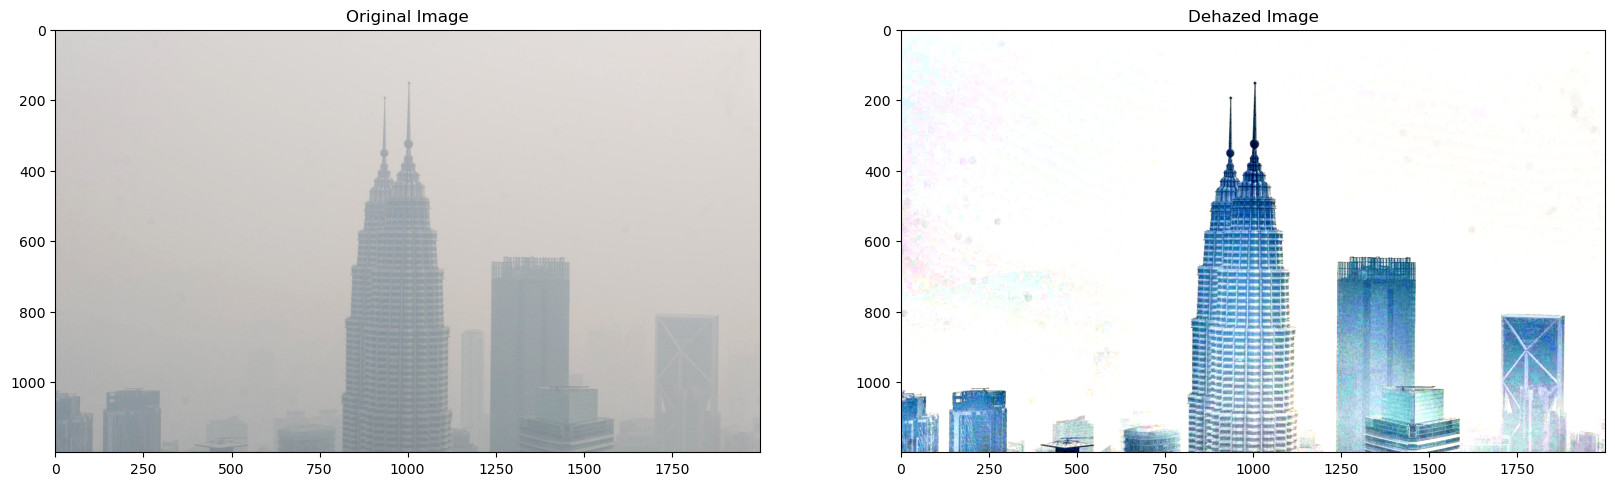

In [154]:
plt.figure(figsize=(20,20))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.title('Dehazed Image')
plt.imshow(dehazed_img)
plt.show()